# 5.0 Machine Learning
We will train several models on the data, using cross-validation to pick the best hyperparameters, and select the most promising model. The model will finally be evaulated on the test set.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_columns', 200)

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_squared_error, make_scorer
   
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
np.random.seed(101)

### Read in the data

In [4]:
DATA_FOLDER = os.path.join('data', 'final')

In [5]:
zoopla_df_train = pd.read_csv(os.path.join(DATA_FOLDER, 'zoopla_train.csv'), dtype=str)
zoopla_df_test = pd.read_csv(os.path.join(DATA_FOLDER, 'zoopla_test.csv'), dtype=str)

In [6]:
zoopla_df_train.columns

Index(['TOTAL_FLOOR_AREA_median', 'diff_published_date', 'cluster_1',
       'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6',
       'cluster_7', 'num_bedrooms', 'num_bathrooms',
       'CURRENT_ENERGY_RATING_mode', 'POTENTIAL_ENERGY_RATING_mode',
       'CONSTRUCTION_AGE_BAND_mode', 'Index of Multiple Deprivation Decile',
       'Income Decile', 'Employment Decile', 'Education and Skills Decile',
       'Health and Disability Decile', 'Crime Decile',
       'Barriers to Housing and Services Decile', 'Living Environment Decile',
       'IDACI Decile', 'IDAOPI Decile', 'last_published_year',
       'last_published_month', 'first_published_year', 'first_published_month',
       'post_town_Nuneaton', 'parish_Hinckley and Bosworth, unparished area',
       'parish_Nuneaton and Bedworth, unparished area', 'parish_Other',
       'parish_Stoke Golding', 'postcode_CV10 7', 'postcode_CV10 8',
       'postcode_CV10 9', 'postcode_CV11 4', 'postcode_CV11 5',
       'postcode_CV11 6

In [7]:
X_train = zoopla_df_train.drop('LOG_price', axis=1).astype(float)
y_train = zoopla_df_train['LOG_price'].astype(float)

X_test = zoopla_df_test.drop('LOG_price', axis=1).astype(float)
y_test = zoopla_df_test['LOG_price'].astype(float)

Quick check of variables

In [8]:
X_train.head()

,TOTAL_FLOOR_AREA_median,diff_published_date,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,num_bedrooms,num_bathrooms,CURRENT_ENERGY_RATING_mode,POTENTIAL_ENERGY_RATING_mode,CONSTRUCTION_AGE_BAND_mode,Index of Multiple Deprivation Decile,Income Decile,Employment Decile,Education and Skills Decile,Health and Disability Decile,Crime Decile,Barriers to Housing and Services Decile,Living Environment Decile,IDACI Decile,IDAOPI Decile,last_published_year,last_published_month,first_published_year,first_published_month,post_town_Nuneaton,"parish_Hinckley and Bosworth, unparished area","parish_Nuneaton and Bedworth, unparished area",parish_Other,parish_Stoke Golding,postcode_CV10 7,postcode_CV10 8,postcode_CV10 9,postcode_CV11 4,postcode_CV11 5,postcode_CV11 6,postcode_CV11 7,postcode_CV12 9,postcode_CV13 0,postcode_CV13 6,postcode_LE10 0,postcode_LE10 1,postcode_LE10 2,postcode_LE10 3,postcode_LE9 7,postcode_LE9 8,postcode_LE9 9,PROB_4BAND_Medium,PROB_4BAND_None,property_type_general_Detached house,property_type_general_End terrace house,property_type_general_Flat,property_type_general_Maisonette,property_type_general_Other/Unknown,property_type_general_Semi-detached house,property_type_general_Terraced house
0,0.115918,0.084890,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.114890,0.930600,-1.887397,-1.965158,2.170512,0.771879,1.078753,0.962618,1.783389,0.721555,0.342209,-1.467828,-0.121802,1.266302,1.118847,0.389872,-0.020772,0.835241,-1.165536,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.414918,-0.314965,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.058822,-0.475764,0.467178,1.646290,-0.250040,1.149759,1.078753,0.962618,1.783389,-0.171419,1.580055,0.965677,1.058737,1.266302,1.522063,0.389872,-0.020772,0.835241,-0.897242,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.440317,0.484745,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.028034,0.930600,0.467178,-0.159434,0.052529,1.527639,1.455010,1.372901,1.783389,1.168042,1.580055,-0.251076,1.452250,1.266302,1.118847,0.389872,-0.375658,-1.150427,1.517406,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.440317,-0.714820,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.028034,-0.475764,0.467178,-0.159434,0.355098,1.527639,1.455010,1.372901,1.783389,0.721555,1.580055,-0.656660,1.452250,1.266302,1.522063,0.389872,-0.020772,0.835241,-0.360653,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.325043,0.084890,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.114890,2.336964,0.467178,1.646290,-0.552609,-0.361760,-0.426275,-0.678513,-0.697277,-0.171419,-0.483022,0.154508,0.271711,-0.329238,-0.494021,0.389872,-1.085430,-1.150427,1.517406,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
for colname in X_train.columns:
    display(X_train[colname].value_counts(dropna=False))

-0.208482    168
-0.444409     25
-0.237973     22
 0.115918     19
-0.650845     16
            ... 
-0.606609      1
 0.690990      1
-0.817468      1
 0.023464      1
-0.865391      1
Name: TOTAL_FLOOR_AREA_median, Length: 286, dtype: int64

-0.714820    442
-0.314965    179
 0.084890    120
 0.484745     78
 0.884600     50
 1.284455     50
 1.684310     31
 2.084165     24
 2.484020     13
 2.883875      8
 3.283731      4
 4.883151      3
 4.083441      3
 3.683586      1
 7.682136      1
 6.882426      1
Name: diff_published_date, dtype: int64

0.0    834
1.0    174
Name: cluster_1, dtype: int64

0.0    901
1.0    107
Name: cluster_2, dtype: int64

0.0    882
1.0    126
Name: cluster_3, dtype: int64

0.0    831
1.0    177
Name: cluster_4, dtype: int64

0.0    915
1.0     93
Name: cluster_5, dtype: int64

0.0    899
1.0    109
Name: cluster_6, dtype: int64

0.0    887
1.0    121
Name: cluster_7, dtype: int64

 0.028034    459
-1.058822    260
 1.114890    216
 2.201746     36
-2.145678     24
-3.232533      8
 4.375457      3
 3.288601      2
Name: num_bedrooms, dtype: int64

-0.475764    593
 0.930600    285
-1.882128     70
 2.336964     54
 3.743328      6
Name: num_bathrooms, dtype: int64

 0.467178    581
-0.710110    192
-1.887397    149
 1.644465     82
 2.821752      4
Name: CURRENT_ENERGY_RATING_mode, dtype: int64

-0.159434    715
 1.646290    179
-1.965158    106
 3.452014      8
Name: POTENTIAL_ENERGY_RATING_mode, dtype: int64

-0.855178    363
-0.552609    102
 0.052529     93
-0.250040     80
 1.565374     65
 0.657667     59
 1.262805     53
 2.170512     51
 0.355098     37
-1.157747     37
 0.960236     37
 1.867943     31
Name: CONSTRUCTION_AGE_BAND_mode, dtype: int64

 0.771879    243
-0.739640    119
 0.016120    112
-0.361760    108
-1.117519     99
 1.149759     93
 1.527639     81
-1.873279     67
-1.495399     48
 0.394000     38
Name: Index of Multiple Deprivation Decile, dtype: int64

 1.078753    221
 0.326239    155
-0.426275    140
-0.802532    110
-1.178789     90
 1.455010     83
-0.050018     63
-1.555046     57
-1.931303     48
 0.702496     41
Name: Income Decile, dtype: int64

 0.142052    217
 0.962618    168
 1.372901    129
-0.678513    125
-1.088796    106
-1.499079     75
-0.268231     64
 0.552335     59
-1.909362     51
 1.783184     14
Name: Employment Decile, dtype: int64

 0.129612    206
-0.697277    163
-0.283833    153
 1.369945    127
-1.524166     98
-1.110721     97
 1.783389     68
 0.956500     53
 0.543056     32
 2.196833     11
Name: Education and Skills Decile, dtype: int64

-0.617906    185
-0.171419    150
 0.275068    139
 0.721555    132
-1.064393    102
 1.614528     98
-1.510880     83
 1.168042     70
-1.957367     25
 2.061015     24
Name: Health and Disability Decile, dtype: int64

-0.483022    228
 0.754824    141
 0.342209    131
-0.895638    109
 1.167440     81
-1.720869     79
-0.070407     73
 1.580055     64
-1.308253     61
 1.992671     41
Name: Crime Decile, dtype: int64

 0.560092    204
 0.965677    166
-1.062244    163
 0.154508    133
 1.371261    107
-1.467828    103
-0.656660     64
-0.251076     39
-2.278997     28
-1.873413      1
Name: Barriers to Housing and Services Decile, dtype: int64

-0.121802    226
 1.058737    161
-0.908827    144
 1.452250    127
-1.695853     84
 0.665224     81
-0.515314     66
 0.271711     58
-1.302340     48
-2.089365     13
Name: Living Environment Decile, dtype: int64

-0.329238    189
 0.867417    155
 1.266302    136
-0.728123    116
 0.069647    105
 0.468532     85
-1.924778     67
-1.525893     59
-1.127008     53
 1.665187     43
Name: IDACI Decile, dtype: int64

-0.494021    195
 1.118847    153
 0.715630    134
-0.090804    110
-0.897237    106
 1.522063     89
 0.312413     87
-1.703671     70
-2.106888     32
-1.300454     32
Name: IDAOPI Decile, dtype: int64

 0.389872    875
-2.564946    133
Name: last_published_year, dtype: int64

-0.020772    432
-0.375658    183
-0.730544    131
-1.085430    129
 2.463431     40
 2.818317     39
 2.108545     36
 1.753659     11
 1.398772      7
Name: last_published_month, dtype: int64

 0.835241    589
-1.150427    414
-3.136095      5
Name: first_published_year, dtype: int64

-0.628948    170
-1.165536    162
-0.360653    154
-0.897242    119
 1.249112    103
 1.517406     88
 0.980817     67
 0.712523     49
 1.785700     46
 0.444229     25
 0.175935     16
-0.092359      9
Name: first_published_month, dtype: int64

1.0    675
0.0    333
Name: post_town_Nuneaton, dtype: int64

0.0    688
1.0    320
Name: parish_Hinckley and Bosworth, unparished area, dtype: int64

1.0    642
0.0    366
Name: parish_Nuneaton and Bedworth, unparished area, dtype: int64

0.0    993
1.0     15
Name: parish_Other, dtype: int64

0.0    991
1.0     17
Name: parish_Stoke Golding, dtype: int64

0.0    941
1.0     67
Name: postcode_CV10 7, dtype: int64

0.0    941
1.0     67
Name: postcode_CV10 8, dtype: int64

0.0    897
1.0    111
Name: postcode_CV10 9, dtype: int64

0.0    924
1.0     84
Name: postcode_CV11 4, dtype: int64

0.0    954
1.0     54
Name: postcode_CV11 5, dtype: int64

0.0    869
1.0    139
Name: postcode_CV11 6, dtype: int64

0.0    988
1.0     20
Name: postcode_CV11 7, dtype: int64

0.0    1006
1.0       2
Name: postcode_CV12 9, dtype: int64

0.0    1005
1.0       3
Name: postcode_CV13 0, dtype: int64

0.0    982
1.0     26
Name: postcode_CV13 6, dtype: int64

0.0    807
1.0    201
Name: postcode_LE10 0, dtype: int64

0.0    894
1.0    114
Name: postcode_LE10 1, dtype: int64

0.0    1000
1.0       8
Name: postcode_LE10 2, dtype: int64

0.0    997
1.0     11
Name: postcode_LE10 3, dtype: int64

0.0    1007
1.0       1
Name: postcode_LE9 7, dtype: int64

0.0    1007
1.0       1
Name: postcode_LE9 8, dtype: int64

0.0    1007
1.0       1
Name: postcode_LE9 9, dtype: int64

0.0    996
1.0     12
Name: PROB_4BAND_Medium, dtype: int64

1.0    994
0.0     14
Name: PROB_4BAND_None, dtype: int64

0.0    691
1.0    317
Name: property_type_general_Detached house, dtype: int64

0.0    957
1.0     51
Name: property_type_general_End terrace house, dtype: int64

0.0    923
1.0     85
Name: property_type_general_Flat, dtype: int64

0.0    1000
1.0       8
Name: property_type_general_Maisonette, dtype: int64

0.0    979
1.0     29
Name: property_type_general_Other/Unknown, dtype: int64

0.0    730
1.0    278
Name: property_type_general_Semi-detached house, dtype: int64

0.0    834
1.0    174
Name: property_type_general_Terraced house, dtype: int64

In [10]:
def predict_evaluate(model, X, y, actual_prices=False):
    
    """
    Predict a model on X and evaluate predictions vs actual values y for RMSE. Then plot RMSE vs y
    If actual_prices = True, then convert y values (which are logs) to raw values
    """
    
    y_preds = model.predict(X)
    label = 'LOG(Price)'
    
    if actual_prices:
        y = np.exp(y)
        y_preds = np.exp(y_preds)
        label = 'Price'
    
    print('RSME =', mean_squared_error(y, y_preds, squared=False))
    plt.plot(y, y_preds-y, 'b.')
    plt.xlabel(label)
    plt.ylabel('Predicted - Acual')
    plt.grid()
    

### Try fitting a simple linear regression model

RSME = 52121.12755032847


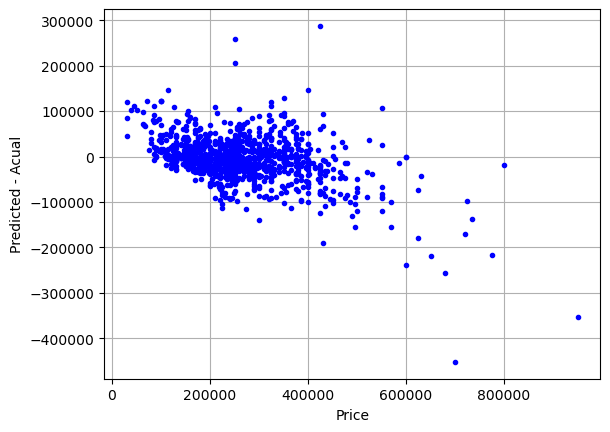

In [11]:
simple_lin_model = LinearRegression()
simple_lin_model.fit(X_train, y_train)

predict_evaluate(simple_lin_model, X_train, y_train, True)

### Try Ridge and Lasso Regression
We will try out different values of the hyperparameters using cross-validation

In [12]:
def RMSE(y_true, y_pred):
    
    """Make personalised scorer, in this case RMSE, for use in cross-validation"""
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE: %2.3f', rmse)
    return rmse

rmse = make_scorer(RMSE, greater_is_better=False)

Ridge regression

In [13]:
# Higher alpha = more regularisation
ridge_model_param_grid = {'alpha': [0, 0.001, 0.01, 0.1, 1, 2, 3, 5, 10], 'max_iter': [10000]}

# Scan all values of alpha and pick the one that optimises RMSE (from our scorer above)
grid_search_ridge_model = GridSearchCV(Ridge(random_state=101), ridge_model_param_grid, cv=5, verbose=3, scoring=rmse)
grid_search_ridge_model.fit(X_train, y_train)

print("Best value for alpha =", grid_search_ridge_model.best_params_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
RMSE: %2.3f 9289713672786.48
[CV 1/5] END alpha=0, max_iter=10000;, score=-9289713672786.480 total time=   0.0s
RMSE: %2.3f 2358165637320.1587
[CV 2/5] END alpha=0, max_iter=10000;, score=-2358165637320.159 total time=   0.0s
RMSE: %2.3f 16128516314980.49
[CV 3/5] END alpha=0, max_iter=10000;, score=-16128516314980.490 total time=   0.0s
RMSE: %2.3f 896546023995.7396
[CV 4/5] END alpha=0, max_iter=10000;, score=-896546023995.740 total time=   0.0s
RMSE: %2.3f 0.2074012129589792
[CV 5/5] END ..........alpha=0, max_iter=10000;, score=-0.207 total time=   0.0s
RMSE: %2.3f 0.2659722631178702
[CV 1/5] END ......alpha=0.001, max_iter=10000;, score=-0.266 total time=   0.0s
RMSE: %2.3f 0.22275147149209074
[CV 2/5] END ......alpha=0.001, max_iter=10000;, score=-0.223 total time=   0.0s
RMSE: %2.3f 0.25934966911838403
[CV 3/5] END ......alpha=0.001, max_iter=10000;, score=-0.259 total time=   0.0s
RMSE: %2.3f 0.21397432722259538
[CV 4/

RSME = 52157.624932086626


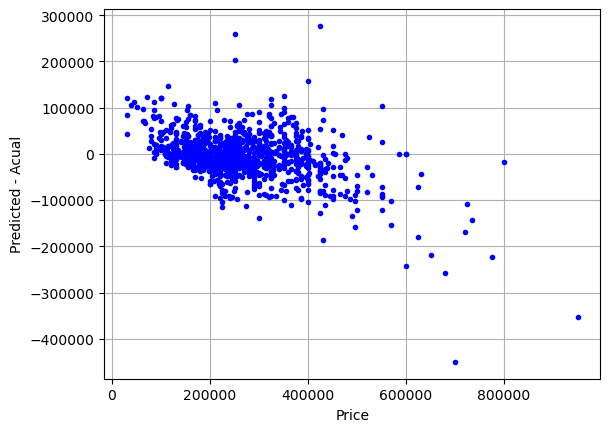

In [14]:
# pick best model and evaluate on training set for now
predict_evaluate(grid_search_ridge_model.best_estimator_, X_train, y_train, True)

Lasso regression

In [15]:
# Higher alpha = more regularisation
lasso_model_param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 5, 10], 'max_iter': [10000]}

grid_search_lasso_model = GridSearchCV(Lasso(random_state=101), lasso_model_param_grid, cv=5, verbose=3, scoring=rmse)
grid_search_lasso_model.fit(X_train, y_train)

print("Best value for alpha =", grid_search_lasso_model.best_params_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
RMSE: %2.3f 0.26667763660868465
[CV 1/5] END .....alpha=0.0001, max_iter=10000;, score=-0.267 total time=   0.0s
RMSE: %2.3f 0.22233167546336766
[CV 2/5] END .....alpha=0.0001, max_iter=10000;, score=-0.222 total time=   0.0s
RMSE: %2.3f 0.2596159547911595
[CV 3/5] END .....alpha=0.0001, max_iter=10000;, score=-0.260 total time=   0.0s
RMSE: %2.3f 0.21386537246863999
[CV 4/5] END .....alpha=0.0001, max_iter=10000;, score=-0.214 total time=   0.0s
RMSE: %2.3f 0.20579286893074777
[CV 5/5] END .....alpha=0.0001, max_iter=10000;, score=-0.206 total time=   0.1s
RMSE: %2.3f 0.26872752154316376
[CV 1/5] END ......alpha=0.001, max_iter=10000;, score=-0.269 total time=   0.0s
RMSE: %2.3f 0.22413506385991575
[CV 2/5] END ......alpha=0.001, max_iter=10000;, score=-0.224 total time=   0.0s
RMSE: %2.3f 0.26131775893638104
[CV 3/5] END ......alpha=0.001, max_iter=10000;, score=-0.261 total time=   0.0s
RMSE: %2.3f 0.2180876061865993
[CV 4/

RSME = 52131.48762185076


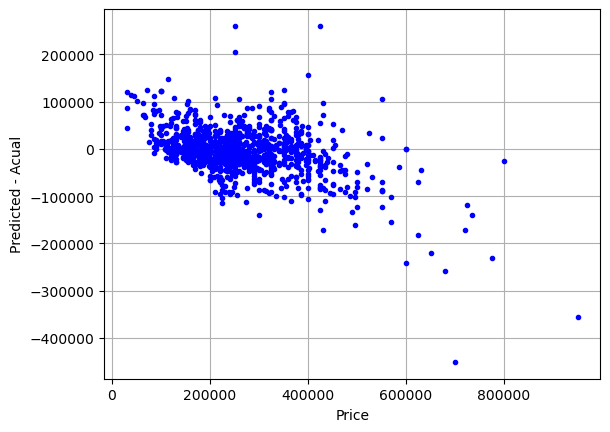

In [16]:
# pick best model and evaluate on training set for now
predict_evaluate(grid_search_lasso_model.best_estimator_, X_train, y_train, True)

### Now try KNN Regressor

In [17]:
# Smaller C = more regularisation
knn_model_param_grid = {'n_neighbors': [k for k in range(1, 51)]}

grid_search_knn_model = GridSearchCV(KNeighborsRegressor(), knn_model_param_grid, cv=5, verbose=3, scoring=rmse)
grid_search_knn_model.fit(X_train, y_train)

print("Best value for k =", grid_search_knn_model.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
RMSE: %2.3f 0.3949707555308482
[CV 1/5] END ....................n_neighbors=1;, score=-0.395 total time=   0.0s
RMSE: %2.3f 0.3628520870148655
[CV 2/5] END ....................n_neighbors=1;, score=-0.363 total time=   0.0s
RMSE: %2.3f 0.37537433715506074
[CV 3/5] END ....................n_neighbors=1;, score=-0.375 total time=   0.0s
RMSE: %2.3f 0.34273332250799826
[CV 4/5] END ....................n_neighbors=1;, score=-0.343 total time=   0.0s
RMSE: %2.3f 0.32419543825270736
[CV 5/5] END ....................n_neighbors=1;, score=-0.324 total time=   0.0s
RMSE: %2.3f 0.3582030637925077
[CV 1/5] END ....................n_neighbors=2;, score=-0.358 total time=   0.0s
RMSE: %2.3f 0.34685006438110405
[CV 2/5] END ....................n_neighbors=2;, score=-0.347 total time=   0.0s
RMSE: %2.3f 0.3338449143208231
[CV 3/5] END ....................n_neighbors=2;, score=-0.334 total time=   0.0s
RMSE: %2.3f 0.300001050516451
[CV 4/5]

RMSE: %2.3f 0.35089973915023887
[CV 1/5] END ...................n_neighbors=19;, score=-0.351 total time=   0.1s
RMSE: %2.3f 0.29944681258148226
[CV 2/5] END ...................n_neighbors=19;, score=-0.299 total time=   0.0s
RMSE: %2.3f 0.3298926111258302
[CV 3/5] END ...................n_neighbors=19;, score=-0.330 total time=   0.0s
RMSE: %2.3f 0.3219259896981526
[CV 4/5] END ...................n_neighbors=19;, score=-0.322 total time=   0.0s
RMSE: %2.3f 0.2947987457103862
[CV 5/5] END ...................n_neighbors=19;, score=-0.295 total time=   0.0s
RMSE: %2.3f 0.3519747854427523
[CV 1/5] END ...................n_neighbors=20;, score=-0.352 total time=   0.0s
RMSE: %2.3f 0.2976154381257011
[CV 2/5] END ...................n_neighbors=20;, score=-0.298 total time=   0.0s
RMSE: %2.3f 0.33298856279898753
[CV 3/5] END ...................n_neighbors=20;, score=-0.333 total time=   0.0s
RMSE: %2.3f 0.32309949225835083
[CV 4/5] END ...................n_neighbors=20;, score=-0.323 total t

RMSE: %2.3f 0.3496052527923464
[CV 3/5] END ...................n_neighbors=35;, score=-0.350 total time=   0.0s
RMSE: %2.3f 0.33090243344503734
[CV 4/5] END ...................n_neighbors=35;, score=-0.331 total time=   0.0s
RMSE: %2.3f 0.30520887398402724
[CV 5/5] END ...................n_neighbors=35;, score=-0.305 total time=   0.0s
RMSE: %2.3f 0.36571790606953475
[CV 1/5] END ...................n_neighbors=36;, score=-0.366 total time=   0.0s
RMSE: %2.3f 0.31259264816001475
[CV 2/5] END ...................n_neighbors=36;, score=-0.313 total time=   0.0s
RMSE: %2.3f 0.34942953237256635
[CV 3/5] END ...................n_neighbors=36;, score=-0.349 total time=   0.0s
RMSE: %2.3f 0.33117096821557446
[CV 4/5] END ...................n_neighbors=36;, score=-0.331 total time=   0.0s
RMSE: %2.3f 0.3053245070678421
[CV 5/5] END ...................n_neighbors=36;, score=-0.305 total time=   0.0s
RMSE: %2.3f 0.3668687516442262
[CV 1/5] END ...................n_neighbors=37;, score=-0.367 total

RSME = 63809.78545624292


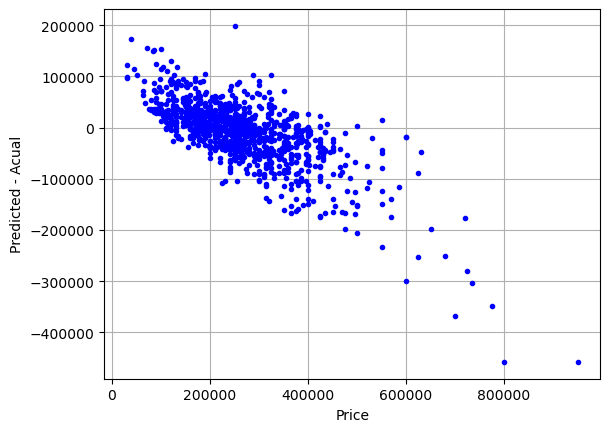

In [18]:
# evaluate
predict_evaluate(grid_search_knn_model.best_estimator_, X_train, y_train, True)

### Now try Support Vector Regressor

In [19]:
svr_param_search = {
    'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2, 4, 8], 
    'gamma': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2, 4, 8], 
    'kernel': ['rbf', 'poly']}

random_search_svr_model = RandomizedSearchCV(SVR(), svr_param_search, n_iter=50, cv=5, verbose=3, scoring=rmse, random_state=101)
random_search_svr_model.fit(X_train, y_train)

print("Best hyperparameters for SVR =", random_search_svr_model.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
RMSE: %2.3f 0.4140232169309732
[CV 1/5] END ...C=0.5, gamma=0.01, kernel=poly;, score=-0.414 total time=   0.0s
RMSE: %2.3f 0.3678643146709698
[CV 2/5] END ...C=0.5, gamma=0.01, kernel=poly;, score=-0.368 total time=   0.0s
RMSE: %2.3f 0.3779012964769457
[CV 3/5] END ...C=0.5, gamma=0.01, kernel=poly;, score=-0.378 total time=   0.0s
RMSE: %2.3f 0.36138151378448535
[CV 4/5] END ...C=0.5, gamma=0.01, kernel=poly;, score=-0.361 total time=   0.0s
RMSE: %2.3f 0.3367777904580361
[CV 5/5] END ...C=0.5, gamma=0.01, kernel=poly;, score=-0.337 total time=   0.0s
RMSE: %2.3f 0.3538448186307073
[CV 1/5] END ....C=0.001, gamma=2, kernel=poly;, score=-0.354 total time=   0.1s
RMSE: %2.3f 0.3276758700977938
[CV 2/5] END ....C=0.001, gamma=2, kernel=poly;, score=-0.328 total time=   0.1s
RMSE: %2.3f 0.31057868210919937
[CV 3/5] END ....C=0.001, gamma=2, kernel=poly;, score=-0.311 total time=   0.1s
RMSE: %2.3f 0.2853197871633201
[CV 4/5] 

RMSE: %2.3f 0.4351645746829886
[CV 2/5] END .......C=0.1, gamma=4, kernel=rbf;, score=-0.435 total time=   0.1s
RMSE: %2.3f 0.4484537823453764
[CV 3/5] END .......C=0.1, gamma=4, kernel=rbf;, score=-0.448 total time=   0.1s
RMSE: %2.3f 0.44814025768314647
[CV 4/5] END .......C=0.1, gamma=4, kernel=rbf;, score=-0.448 total time=   0.1s
RMSE: %2.3f 0.4047944220908856
[CV 5/5] END .......C=0.1, gamma=4, kernel=rbf;, score=-0.405 total time=   0.1s
RMSE: %2.3f 0.4820014636258521
[CV 1/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.482 total time=   0.1s
RMSE: %2.3f 0.42861668201842085
[CV 2/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.429 total time=   0.1s
RMSE: %2.3f 0.4428637526023315
[CV 3/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.443 total time=   0.1s
RMSE: %2.3f 0.4417281049457086
[CV 4/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.442 total time=   0.1s
RMSE: %2.3f 0.3968644107445962
[CV 5/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.397 total tim

RMSE: %2.3f 0.4412276137391546
[CV 3/5] END .........C=1, gamma=4, kernel=rbf;, score=-0.441 total time=   0.1s
RMSE: %2.3f 0.4353783966391173
[CV 4/5] END .........C=1, gamma=4, kernel=rbf;, score=-0.435 total time=   0.1s
RMSE: %2.3f 0.3925307251856717
[CV 5/5] END .........C=1, gamma=4, kernel=rbf;, score=-0.393 total time=   0.1s
RMSE: %2.3f 0.3538448186307073
[CV 1/5] END ....C=0.001, gamma=4, kernel=poly;, score=-0.354 total time=   0.1s
RMSE: %2.3f 0.32767587009779336
[CV 2/5] END ....C=0.001, gamma=4, kernel=poly;, score=-0.328 total time=   0.1s
RMSE: %2.3f 0.3105786821092067
[CV 3/5] END ....C=0.001, gamma=4, kernel=poly;, score=-0.311 total time=   0.1s
RMSE: %2.3f 0.2853197871633201
[CV 4/5] END ....C=0.001, gamma=4, kernel=poly;, score=-0.285 total time=   0.1s
RMSE: %2.3f 0.29258470928857055
[CV 5/5] END ....C=0.001, gamma=4, kernel=poly;, score=-0.293 total time=   0.1s
RMSE: %2.3f 0.3513031051994533
[CV 1/5] END ....C=2, gamma=0.0001, kernel=rbf;, score=-0.351 total tim

RMSE: %2.3f 0.2621709600824696
[CV 2/5] END .....C=0.5, gamma=0.1, kernel=rbf;, score=-0.262 total time=   0.0s
RMSE: %2.3f 0.29540845487549844
[CV 3/5] END .....C=0.5, gamma=0.1, kernel=rbf;, score=-0.295 total time=   0.0s
RMSE: %2.3f 0.2815414450346992
[CV 4/5] END .....C=0.5, gamma=0.1, kernel=rbf;, score=-0.282 total time=   0.0s
RMSE: %2.3f 0.2431387933835267
[CV 5/5] END .....C=0.5, gamma=0.1, kernel=rbf;, score=-0.243 total time=   0.0s
RMSE: %2.3f 0.4934063466202804
[CV 1/5] END ...C=1, gamma=0.0001, kernel=poly;, score=-0.493 total time=   0.0s
RMSE: %2.3f 0.4375862086111399
[CV 2/5] END ...C=1, gamma=0.0001, kernel=poly;, score=-0.438 total time=   0.0s
RMSE: %2.3f 0.45279633002690806
[CV 3/5] END ...C=1, gamma=0.0001, kernel=poly;, score=-0.453 total time=   0.0s
RMSE: %2.3f 0.45450275816187263
[CV 4/5] END ...C=1, gamma=0.0001, kernel=poly;, score=-0.455 total time=   0.0s
RMSE: %2.3f 0.4103226545383561
[CV 5/5] END ...C=1, gamma=0.0001, kernel=poly;, score=-0.410 total ti

RSME = 35111.31485130931


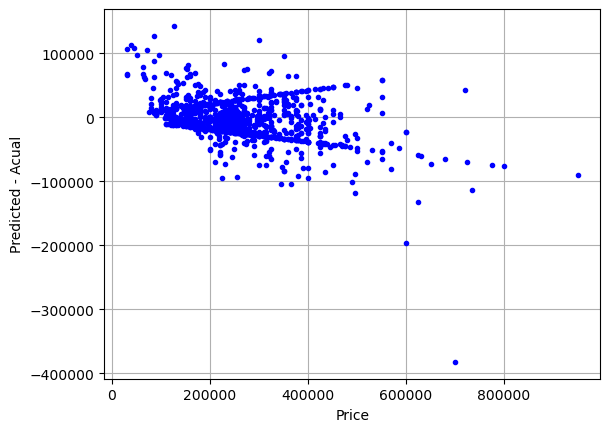

In [20]:
# evaluate
predict_evaluate(random_search_svr_model.best_estimator_, X_train, y_train, True)

### Now try Decision Tree classifier

In [21]:
tree_param_search = {'max_depth': [i for i in range(1, 30)], 'min_samples_split': [i for i in range(2, 30)] }

random_search_tree_model = RandomizedSearchCV(DecisionTreeRegressor(), tree_param_search, n_iter=50,  cv=5, verbose=3, scoring=rmse, random_state=101)
random_search_tree_model.fit(X_train, y_train)

print("Best params =", random_search_tree_model.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
RMSE: %2.3f 0.3313614289978447
[CV 1/5] END max_depth=11, min_samples_split=12;, score=-0.331 total time=   0.1s
RMSE: %2.3f 0.25911607375975526
[CV 2/5] END max_depth=11, min_samples_split=12;, score=-0.259 total time=   0.0s
RMSE: %2.3f 0.28839791737760734
[CV 3/5] END max_depth=11, min_samples_split=12;, score=-0.288 total time=   0.0s
RMSE: %2.3f 0.2633340866286125
[CV 4/5] END max_depth=11, min_samples_split=12;, score=-0.263 total time=   0.0s
RMSE: %2.3f 0.24300407090770468
[CV 5/5] END max_depth=11, min_samples_split=12;, score=-0.243 total time=   0.0s
RMSE: %2.3f 0.33838834801913636
[CV 1/5] END max_depth=2, min_samples_split=10;, score=-0.338 total time=   0.0s
RMSE: %2.3f 0.2702947266695202
[CV 2/5] END max_depth=2, min_samples_split=10;, score=-0.270 total time=   0.0s
RMSE: %2.3f 0.33047888537877557
[CV 3/5] END max_depth=2, min_samples_split=10;, score=-0.330 total time=   0.0s
RMSE: %2.3f 0.30773013884869743


RMSE: %2.3f 0.3299217112397464
[CV 1/5] END max_depth=17, min_samples_split=8;, score=-0.330 total time=   0.0s
RMSE: %2.3f 0.28573780779839336
[CV 2/5] END max_depth=17, min_samples_split=8;, score=-0.286 total time=   0.0s
RMSE: %2.3f 0.2985805241935695
[CV 3/5] END max_depth=17, min_samples_split=8;, score=-0.299 total time=   0.0s
RMSE: %2.3f 0.2742316592849896
[CV 4/5] END max_depth=17, min_samples_split=8;, score=-0.274 total time=   0.0s
RMSE: %2.3f 0.26123931302277487
[CV 5/5] END max_depth=17, min_samples_split=8;, score=-0.261 total time=   0.0s
RMSE: %2.3f 0.3321662897281223
[CV 1/5] END max_depth=25, min_samples_split=10;, score=-0.332 total time=   0.0s
RMSE: %2.3f 0.2748602581851675
[CV 2/5] END max_depth=25, min_samples_split=10;, score=-0.275 total time=   0.0s
RMSE: %2.3f 0.304571227511749
[CV 3/5] END max_depth=25, min_samples_split=10;, score=-0.305 total time=   0.0s
RMSE: %2.3f 0.26915160382569964
[CV 4/5] END max_depth=25, min_samples_split=10;, score=-0.269 total

RMSE: %2.3f 0.2873237346212829
[CV 3/5] END max_depth=28, min_samples_split=18;, score=-0.287 total time=   0.0s
RMSE: %2.3f 0.2706206624517005
[CV 4/5] END max_depth=28, min_samples_split=18;, score=-0.271 total time=   0.0s
RMSE: %2.3f 0.23648332037936812
[CV 5/5] END max_depth=28, min_samples_split=18;, score=-0.236 total time=   0.0s
RMSE: %2.3f 0.338388348019136
[CV 1/5] END max_depth=2, min_samples_split=29;, score=-0.338 total time=   0.0s
RMSE: %2.3f 0.27029472666952004
[CV 2/5] END max_depth=2, min_samples_split=29;, score=-0.270 total time=   0.0s
RMSE: %2.3f 0.33047888537877473
[CV 3/5] END max_depth=2, min_samples_split=29;, score=-0.330 total time=   0.0s
RMSE: %2.3f 0.30773013884869704
[CV 4/5] END max_depth=2, min_samples_split=29;, score=-0.308 total time=   0.0s
RMSE: %2.3f 0.28170941801907884
[CV 5/5] END max_depth=2, min_samples_split=29;, score=-0.282 total time=   0.0s
RMSE: %2.3f 0.31702944238611935
[CV 1/5] END max_depth=17, min_samples_split=26;, score=-0.317 to

RSME = 47509.994480086265


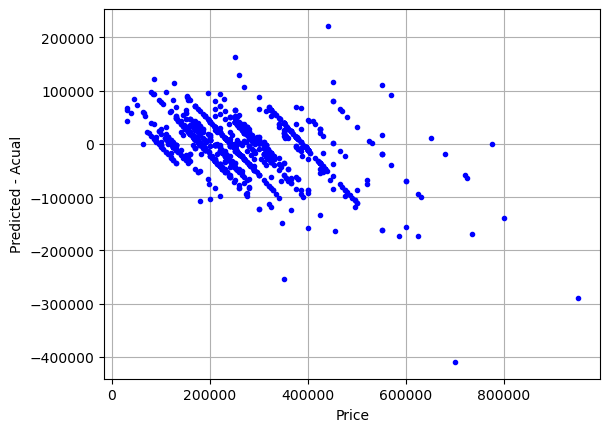

In [22]:
# evaluate
predict_evaluate(random_search_tree_model.best_estimator_, X_train, y_train, True)

Let's look at the best tree. We will fit a decision tree with the best parameters (from the above cross-validation) on the training data and draw the tree

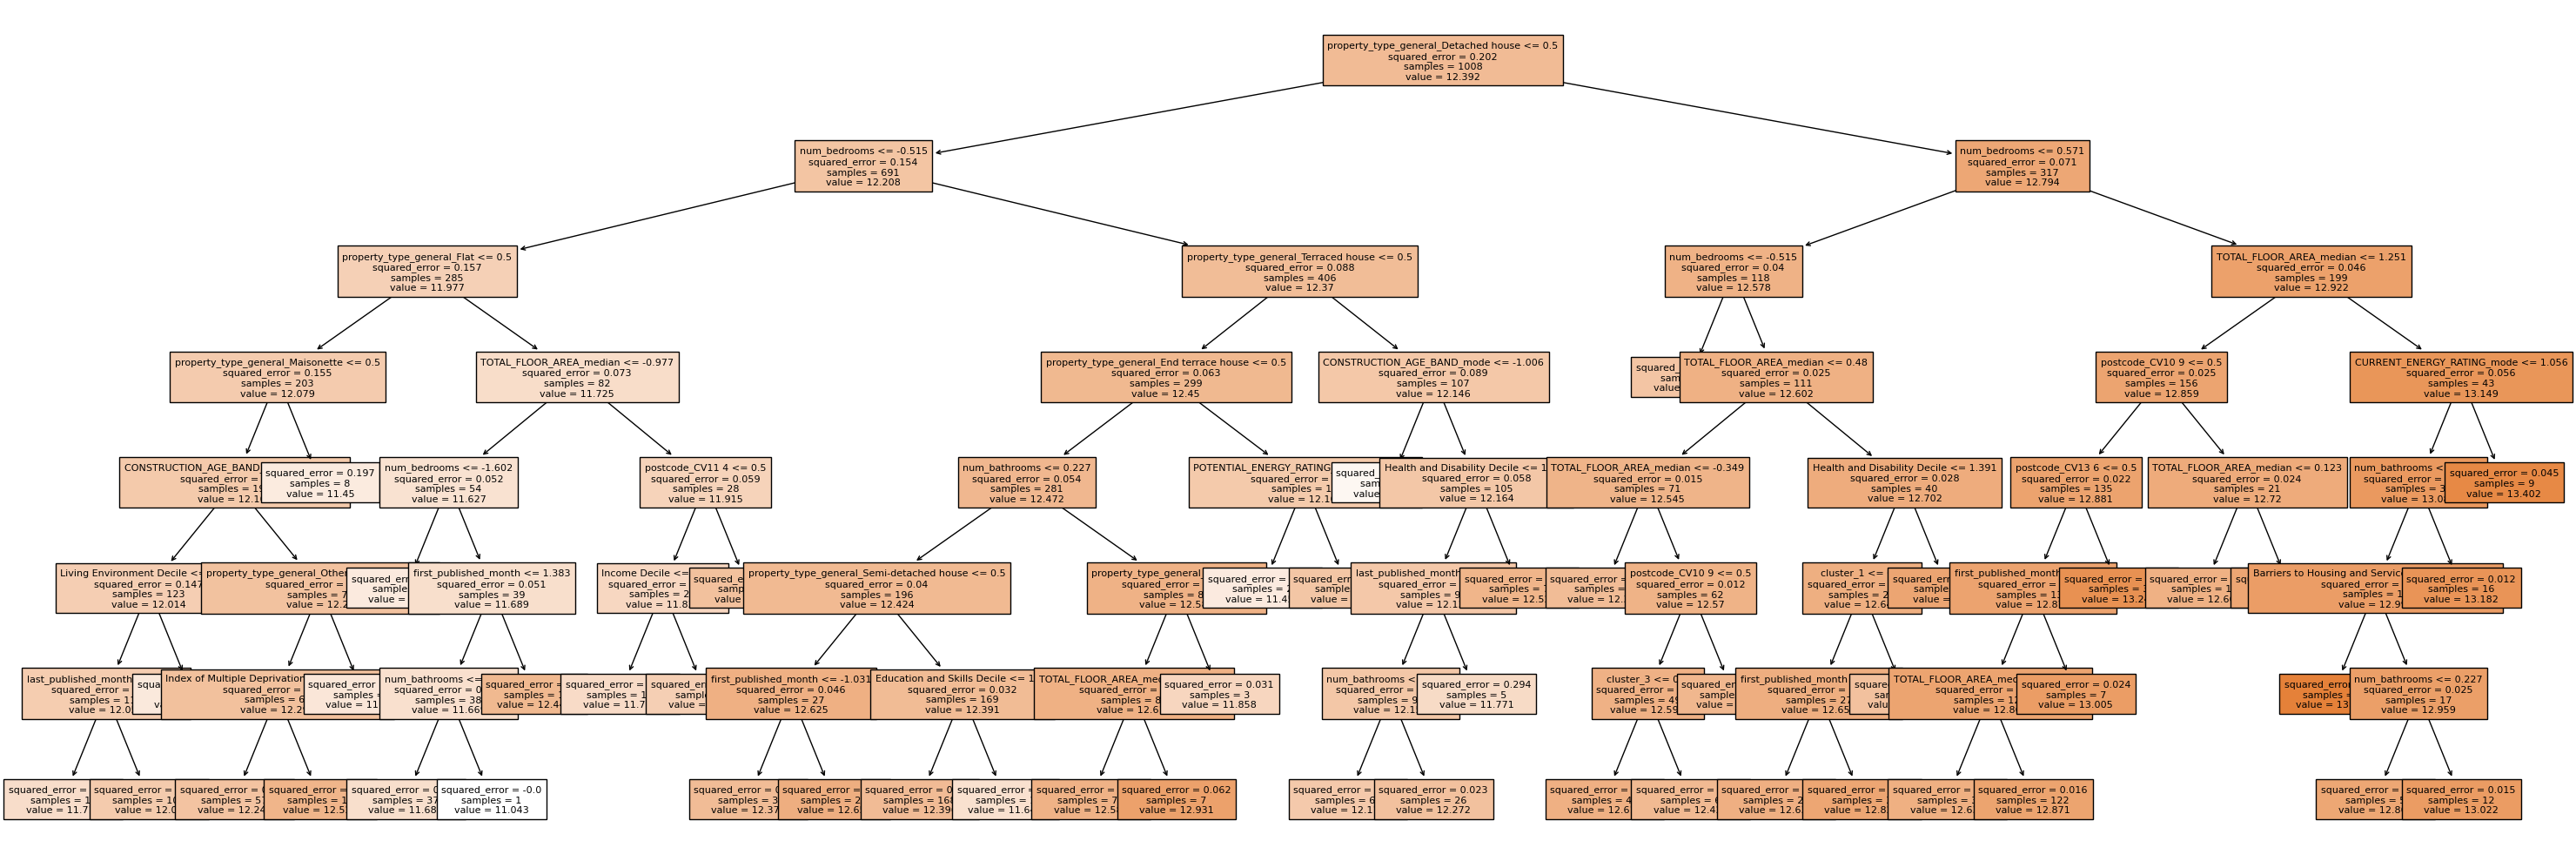

In [23]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30, 10))
plot_t = plot_tree(random_search_tree_model.best_estimator_, feature_names=X_train.columns, filled=True, fontsize=8)
plt.tight_layout()

### Trees not great on their own. Let's try a Random Forest

In [24]:
forest_param_search = {
    'n_estimators': [i for i in range(50, 300)], 
    'max_depth': [i for i in range(1, 10)], 
    'min_samples_split': [i for i in range(2, 30)]
}

random_search_forest_model = RandomizedSearchCV(RandomForestRegressor(), forest_param_search, n_iter=50, cv=5, verbose=3, scoring=rmse, random_state=101)
random_search_forest_model.fit(X_train, y_train)

print("Best params =", random_search_forest_model.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
RMSE: %2.3f 0.26795821952952625
[CV 1/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.268 total time=   0.6s
RMSE: %2.3f 0.22551940135927281
[CV 2/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.226 total time=   0.6s
RMSE: %2.3f 0.2725971414320745
[CV 3/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.273 total time=   0.7s
RMSE: %2.3f 0.24479806255104994
[CV 4/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.245 total time=   0.7s
RMSE: %2.3f 0.20192030176099454
[CV 5/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.202 total time=   0.7s
RMSE: %2.3f 0.29489429186887167
[CV 1/5] END max_depth=3, min_samples_split=17, n_estimators=231;, score=-0.295 total time=   0.4s
RMSE: %2.3f 0.24905376859942951
[CV 2/5] END max_depth=3, min_samples_split=17, n_estimators=231;, score=-0.249 total time=   0.4s
RMSE: %2.3f 0.29950492

RMSE: %2.3f 0.26011235216871037
[CV 4/5] END max_depth=4, min_samples_split=6, n_estimators=198;, score=-0.260 total time=   0.5s
RMSE: %2.3f 0.23045992069914958
[CV 5/5] END max_depth=4, min_samples_split=6, n_estimators=198;, score=-0.230 total time=   0.4s
RMSE: %2.3f 0.2739298964029247
[CV 1/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.274 total time=   0.6s
RMSE: %2.3f 0.22471058782298398
[CV 2/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.225 total time=   0.6s
RMSE: %2.3f 0.27475760392620263
[CV 3/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.275 total time=   0.5s
RMSE: %2.3f 0.24594796597095295
[CV 4/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.246 total time=   0.5s
RMSE: %2.3f 0.2099891836844109
[CV 5/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.210 total time=   0.7s
RMSE: %2.3f 0.2626330691273073
[CV 1/5] END max_depth=8, min_samples_split=22, n_estimators=

RMSE: %2.3f 0.2439542912137532
[CV 2/5] END max_depth=4, min_samples_split=22, n_estimators=156;, score=-0.244 total time=   0.3s
RMSE: %2.3f 0.28812825796782743
[CV 3/5] END max_depth=4, min_samples_split=22, n_estimators=156;, score=-0.288 total time=   0.3s
RMSE: %2.3f 0.2589755378242994
[CV 4/5] END max_depth=4, min_samples_split=22, n_estimators=156;, score=-0.259 total time=   0.4s
RMSE: %2.3f 0.2310145614934072
[CV 5/5] END max_depth=4, min_samples_split=22, n_estimators=156;, score=-0.231 total time=   0.3s
RMSE: %2.3f 0.2636967276538841
[CV 1/5] END max_depth=9, min_samples_split=16, n_estimators=78;, score=-0.264 total time=   0.3s
RMSE: %2.3f 0.2210660975296514
[CV 2/5] END max_depth=9, min_samples_split=16, n_estimators=78;, score=-0.221 total time=   0.4s
RMSE: %2.3f 0.26892284164053937
[CV 3/5] END max_depth=9, min_samples_split=16, n_estimators=78;, score=-0.269 total time=   0.3s
RMSE: %2.3f 0.2339636065912818
[CV 4/5] END max_depth=9, min_samples_split=16, n_estimators

RMSE: %2.3f 0.2018690472793734
[CV 5/5] END max_depth=7, min_samples_split=13, n_estimators=238;, score=-0.202 total time=   1.0s
RMSE: %2.3f 0.29494019295041374
[CV 1/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.295 total time=   0.5s
RMSE: %2.3f 0.2494190689389022
[CV 2/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.249 total time=   0.6s
RMSE: %2.3f 0.29848862715791924
[CV 3/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.298 total time=   0.6s
RMSE: %2.3f 0.26818284528801295
[CV 4/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.268 total time=   0.5s
RMSE: %2.3f 0.24045487010591576
[CV 5/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.240 total time=   0.5s
RMSE: %2.3f 0.2949950802095483
[CV 1/5] END max_depth=3, min_samples_split=26, n_estimators=241;, score=-0.295 total time=   0.4s
RMSE: %2.3f 0.2498797393774459
[CV 2/5] END max_depth=3, min_samples_split=26, n_estimators

RSME = 32688.235281064273


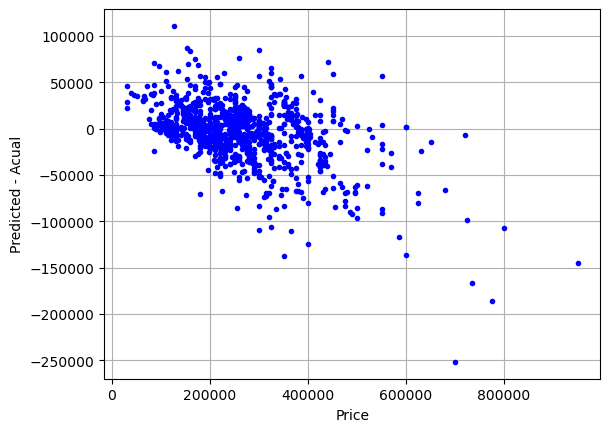

In [25]:
# evaluate
predict_evaluate(random_search_forest_model.best_estimator_, X_train, y_train, True)

Plot feature importances

In [26]:
random_search_forest_model.best_estimator_.feature_importances_

array([4.97221368e-02, 6.31497590e-03, 1.84034998e-03, 1.21242451e-03,
       1.75048630e-03, 9.48288208e-04, 3.98421064e-03, 1.65630065e-03,
       2.54843663e-03, 2.54774466e-01, 2.74395577e-02, 8.18110446e-03,
       1.07791258e-02, 2.53361611e-02, 1.01877715e-02, 7.46749179e-03,
       6.50957739e-03, 1.24057574e-02, 7.69933589e-03, 8.08854813e-03,
       6.32007679e-03, 9.97169623e-03, 6.55766218e-03, 6.44708401e-03,
       2.63140068e-04, 1.51576865e-02, 7.69706999e-04, 9.05390817e-03,
       7.08629137e-04, 8.66977459e-04, 1.29409725e-03, 1.12392436e-03,
       1.22770545e-03, 9.02093163e-04, 6.65255857e-04, 5.05620980e-03,
       4.40340335e-03, 7.55555155e-04, 2.36597484e-03, 2.12213488e-04,
       0.00000000e+00, 0.00000000e+00, 1.61537219e-03, 1.34043644e-03,
       1.40138867e-03, 1.01969772e-04, 1.27795509e-03, 2.67531443e-05,
       1.11246883e-04, 1.05698369e-05, 6.20404476e-04, 2.00200055e-04,
       3.36544516e-01, 1.13486729e-02, 5.44463739e-02, 1.17067274e-02,
      

In [27]:
importances = pd.Series(data=random_search_forest_model.best_estimator_.feature_importances_,
                            index=X_train.columns)

In [28]:
importances = importances.sort_values(ascending=True)

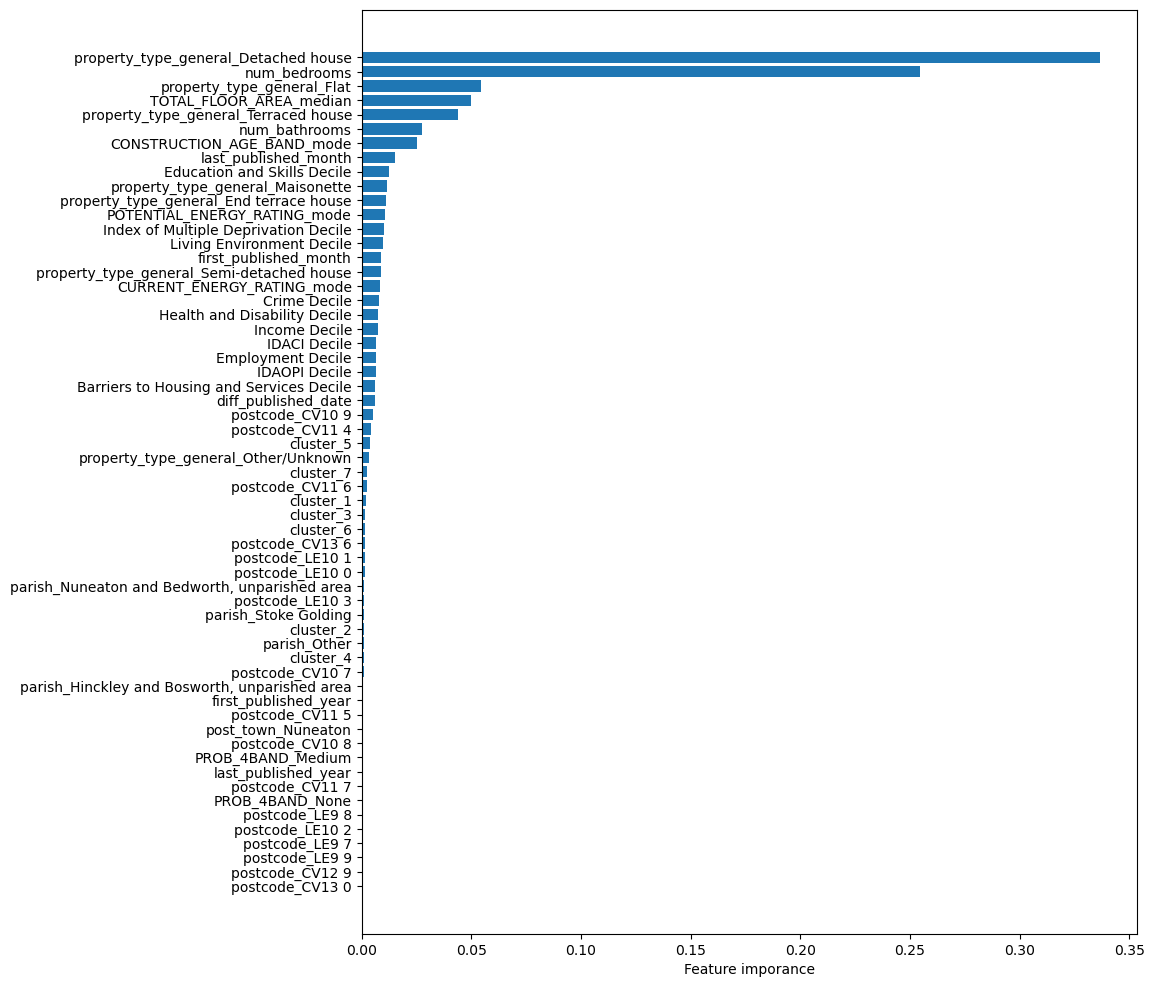

In [29]:
plt.figure(figsize=(10, 12))
plt.barh(range(len(importances)), importances.values)
plt.yticks(range(len(importances)), importances.index);
plt.xlabel('Feature imporance')
plt.show()

### Re-evaluate random forest on most important features

In [30]:
new_cols = importances.index[-30:]

new_random_search_forest_model = RandomizedSearchCV(RandomForestRegressor(), forest_param_search, n_iter=50, cv=5, verbose=3, scoring=rmse, random_state=101)
new_random_search_forest_model.fit(X_train[new_cols], y_train)

print("Best params =", new_random_search_forest_model.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
RMSE: %2.3f 0.26964590776057107
[CV 1/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.270 total time=   0.6s
RMSE: %2.3f 0.22631546944591782
[CV 2/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.226 total time=   0.6s
RMSE: %2.3f 0.2721485622173301
[CV 3/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.272 total time=   0.6s
RMSE: %2.3f 0.24109960773797068
[CV 4/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.241 total time=   0.6s
RMSE: %2.3f 0.20647680152193035
[CV 5/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.206 total time=   0.6s
RMSE: %2.3f 0.29504810769616885
[CV 1/5] END max_depth=3, min_samples_split=17, n_estimators=231;, score=-0.295 total time=   0.4s
RMSE: %2.3f 0.24914573918852256
[CV 2/5] END max_depth=3, min_samples_split=17, n_estimators=231;, score=-0.249 total time=   0.4s
RMSE: %2.3f 0.29722134

RMSE: %2.3f 0.25754526038070946
[CV 4/5] END max_depth=4, min_samples_split=6, n_estimators=198;, score=-0.258 total time=   0.3s
RMSE: %2.3f 0.23215418140503397
[CV 5/5] END max_depth=4, min_samples_split=6, n_estimators=198;, score=-0.232 total time=   0.3s
RMSE: %2.3f 0.2753493662772223
[CV 1/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.275 total time=   0.5s
RMSE: %2.3f 0.2231611103385367
[CV 2/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.223 total time=   0.5s
RMSE: %2.3f 0.2723874750925324
[CV 3/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.272 total time=   0.5s
RMSE: %2.3f 0.24630891982322847
[CV 4/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.246 total time=   0.4s
RMSE: %2.3f 0.21262041372422055
[CV 5/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.213 total time=   0.5s
RMSE: %2.3f 0.26733132298771384
[CV 1/5] END max_depth=8, min_samples_split=22, n_estimators=

RMSE: %2.3f 0.2396068032401154
[CV 2/5] END max_depth=4, min_samples_split=22, n_estimators=156;, score=-0.240 total time=   0.3s
RMSE: %2.3f 0.2861941474824275
[CV 3/5] END max_depth=4, min_samples_split=22, n_estimators=156;, score=-0.286 total time=   0.3s
RMSE: %2.3f 0.25750422419291297
[CV 4/5] END max_depth=4, min_samples_split=22, n_estimators=156;, score=-0.258 total time=   0.3s
RMSE: %2.3f 0.2335298912498645
[CV 5/5] END max_depth=4, min_samples_split=22, n_estimators=156;, score=-0.234 total time=   0.3s
RMSE: %2.3f 0.2637852871567405
[CV 1/5] END max_depth=9, min_samples_split=16, n_estimators=78;, score=-0.264 total time=   0.2s
RMSE: %2.3f 0.21785957654529306
[CV 2/5] END max_depth=9, min_samples_split=16, n_estimators=78;, score=-0.218 total time=   0.2s
RMSE: %2.3f 0.2689492252201586
[CV 3/5] END max_depth=9, min_samples_split=16, n_estimators=78;, score=-0.269 total time=   0.3s
RMSE: %2.3f 0.23084478288942428
[CV 4/5] END max_depth=9, min_samples_split=16, n_estimator

RMSE: %2.3f 0.20297512449244817
[CV 5/5] END max_depth=7, min_samples_split=13, n_estimators=238;, score=-0.203 total time=   0.6s
RMSE: %2.3f 0.2958034204256244
[CV 1/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.296 total time=   0.4s
RMSE: %2.3f 0.2497634538525127
[CV 2/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.250 total time=   0.4s
RMSE: %2.3f 0.2976524634727187
[CV 3/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.298 total time=   0.4s
RMSE: %2.3f 0.26869574879803165
[CV 4/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.269 total time=   0.4s
RMSE: %2.3f 0.24036494773234385
[CV 5/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.240 total time=   0.4s
RMSE: %2.3f 0.29535428931136337
[CV 1/5] END max_depth=3, min_samples_split=26, n_estimators=241;, score=-0.295 total time=   0.4s
RMSE: %2.3f 0.24882084340348853
[CV 2/5] END max_depth=3, min_samples_split=26, n_estimator

RSME = 40505.58443412216


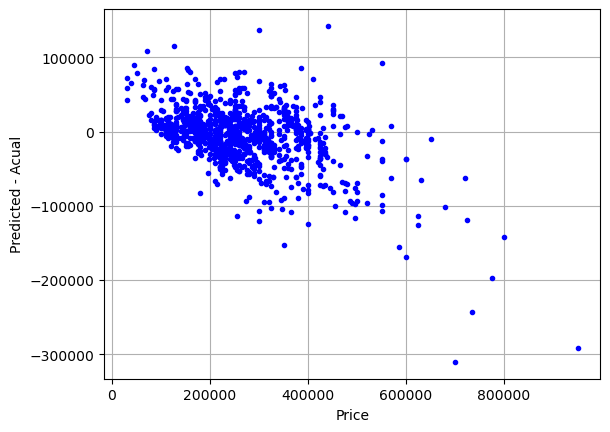

In [31]:
# evaluate
predict_evaluate(new_random_search_forest_model.best_estimator_, X_train[new_cols], y_train, True)

Performs very similarly but not quite as well as expected

### Try performing PCA on the features

In [32]:
random_forest_pca_pipeline = Pipeline([
    ('pca', PCA()),
    ('rforest', RandomForestRegressor())
])

forest_param_search_2 = {
    'pca__n_components': [i for i in range(1, len(X_train.columns))],
    'rforest__n_estimators': [i for i in range(50, 300)], 
    'rforest__max_depth': [i for i in range(1, 10)], 
    'rforest__min_samples_split': [i for i in range(2, 30)]
}


random_search_forest_model_with_pca = RandomizedSearchCV(random_forest_pca_pipeline, forest_param_search_2, n_iter=50, cv=5, verbose=3, scoring=rmse, random_state=101)
random_search_forest_model_with_pca.fit(X_train, y_train)

print("Best params =", random_search_forest_model_with_pca.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
RMSE: %2.3f 0.3148862243885166
[CV 1/5] END pca__n_components=53, rforest__max_depth=7, rforest__min_samples_split=20, rforest__n_estimators=269;, score=-0.315 total time=   3.5s
RMSE: %2.3f 0.2724702198535739
[CV 2/5] END pca__n_components=53, rforest__max_depth=7, rforest__min_samples_split=20, rforest__n_estimators=269;, score=-0.272 total time=   3.6s
RMSE: %2.3f 0.30458871178488905
[CV 3/5] END pca__n_components=53, rforest__max_depth=7, rforest__min_samples_split=20, rforest__n_estimators=269;, score=-0.305 total time=   3.5s
RMSE: %2.3f 0.2862149079696993
[CV 4/5] END pca__n_components=53, rforest__max_depth=7, rforest__min_samples_split=20, rforest__n_estimators=269;, score=-0.286 total time=   3.5s
RMSE: %2.3f 0.23996105501741252
[CV 5/5] END pca__n_components=53, rforest__max_depth=7, rforest__min_samples_split=20, rforest__n_estimators=269;, score=-0.240 total time=   3.5s
RMSE: %2.3f 0.3435535290401793
[CV 1/5] E

RMSE: %2.3f 0.40108604443333257
[CV 2/5] END pca__n_components=20, rforest__max_depth=1, rforest__min_samples_split=20, rforest__n_estimators=254;, score=-0.401 total time=   0.6s
RMSE: %2.3f 0.40047478179314977
[CV 3/5] END pca__n_components=20, rforest__max_depth=1, rforest__min_samples_split=20, rforest__n_estimators=254;, score=-0.400 total time=   0.6s
RMSE: %2.3f 0.4006483333941793
[CV 4/5] END pca__n_components=20, rforest__max_depth=1, rforest__min_samples_split=20, rforest__n_estimators=254;, score=-0.401 total time=   0.6s
RMSE: %2.3f 0.3779890259314435
[CV 5/5] END pca__n_components=20, rforest__max_depth=1, rforest__min_samples_split=20, rforest__n_estimators=254;, score=-0.378 total time=   0.6s
RMSE: %2.3f 0.40513003948635407
[CV 1/5] END pca__n_components=23, rforest__max_depth=2, rforest__min_samples_split=23, rforest__n_estimators=204;, score=-0.405 total time=   0.7s
RMSE: %2.3f 0.37261463678009815
[CV 2/5] END pca__n_components=23, rforest__max_depth=2, rforest__min_

RMSE: %2.3f 0.3416534873538017
[CV 3/5] END pca__n_components=36, rforest__max_depth=3, rforest__min_samples_split=2, rforest__n_estimators=63;, score=-0.342 total time=   0.5s
RMSE: %2.3f 0.33969604603609616
[CV 4/5] END pca__n_components=36, rforest__max_depth=3, rforest__min_samples_split=2, rforest__n_estimators=63;, score=-0.340 total time=   0.5s
RMSE: %2.3f 0.30803800290268685
[CV 5/5] END pca__n_components=36, rforest__max_depth=3, rforest__min_samples_split=2, rforest__n_estimators=63;, score=-0.308 total time=   0.5s
RMSE: %2.3f 0.40752641901764924
[CV 1/5] END pca__n_components=34, rforest__max_depth=2, rforest__min_samples_split=17, rforest__n_estimators=168;, score=-0.408 total time=   0.7s
RMSE: %2.3f 0.3728729735742821
[CV 2/5] END pca__n_components=34, rforest__max_depth=2, rforest__min_samples_split=17, rforest__n_estimators=168;, score=-0.373 total time=   0.8s
RMSE: %2.3f 0.3667313702663642
[CV 3/5] END pca__n_components=34, rforest__max_depth=2, rforest__min_samples

RMSE: %2.3f 0.3987524012122336
[CV 4/5] END pca__n_components=6, rforest__max_depth=1, rforest__min_samples_split=5, rforest__n_estimators=63;, score=-0.399 total time=   0.2s
RMSE: %2.3f 0.38155099246037405
[CV 5/5] END pca__n_components=6, rforest__max_depth=1, rforest__min_samples_split=5, rforest__n_estimators=63;, score=-0.382 total time=   0.2s
RMSE: %2.3f 0.31193715491714497
[CV 1/5] END pca__n_components=14, rforest__max_depth=8, rforest__min_samples_split=15, rforest__n_estimators=83;, score=-0.312 total time=   0.5s
RMSE: %2.3f 0.30054925782318176
[CV 2/5] END pca__n_components=14, rforest__max_depth=8, rforest__min_samples_split=15, rforest__n_estimators=83;, score=-0.301 total time=   0.5s
RMSE: %2.3f 0.3130908346646264
[CV 3/5] END pca__n_components=14, rforest__max_depth=8, rforest__min_samples_split=15, rforest__n_estimators=83;, score=-0.313 total time=   0.5s
RMSE: %2.3f 0.2704465382602994
[CV 4/5] END pca__n_components=14, rforest__max_depth=8, rforest__min_samples_sp

RMSE: %2.3f 0.33931977395611423
[CV 5/5] END pca__n_components=51, rforest__max_depth=2, rforest__min_samples_split=18, rforest__n_estimators=214;, score=-0.339 total time=   1.3s
RMSE: %2.3f 0.4502362038714094
[CV 1/5] END pca__n_components=20, rforest__max_depth=1, rforest__min_samples_split=13, rforest__n_estimators=139;, score=-0.450 total time=   0.4s
RMSE: %2.3f 0.3972223933199032
[CV 2/5] END pca__n_components=20, rforest__max_depth=1, rforest__min_samples_split=13, rforest__n_estimators=139;, score=-0.397 total time=   0.4s
RMSE: %2.3f 0.4011921417442071
[CV 3/5] END pca__n_components=20, rforest__max_depth=1, rforest__min_samples_split=13, rforest__n_estimators=139;, score=-0.401 total time=   0.4s
RMSE: %2.3f 0.3995412362708464
[CV 4/5] END pca__n_components=20, rforest__max_depth=1, rforest__min_samples_split=13, rforest__n_estimators=139;, score=-0.400 total time=   0.4s
RMSE: %2.3f 0.3796772243878794
[CV 5/5] END pca__n_components=20, rforest__max_depth=1, rforest__min_sam

RMSE: %2.3f 0.45176956845121186
[CV 1/5] END pca__n_components=13, rforest__max_depth=1, rforest__min_samples_split=23, rforest__n_estimators=206;, score=-0.452 total time=   0.4s
RMSE: %2.3f 0.4013797154291077
[CV 2/5] END pca__n_components=13, rforest__max_depth=1, rforest__min_samples_split=23, rforest__n_estimators=206;, score=-0.401 total time=   0.4s
RMSE: %2.3f 0.4010275517512688
[CV 3/5] END pca__n_components=13, rforest__max_depth=1, rforest__min_samples_split=23, rforest__n_estimators=206;, score=-0.401 total time=   0.4s
RMSE: %2.3f 0.39943681479824295
[CV 4/5] END pca__n_components=13, rforest__max_depth=1, rforest__min_samples_split=23, rforest__n_estimators=206;, score=-0.399 total time=   0.4s
RMSE: %2.3f 0.37784424394011334
[CV 5/5] END pca__n_components=13, rforest__max_depth=1, rforest__min_samples_split=23, rforest__n_estimators=206;, score=-0.378 total time=   0.4s
RMSE: %2.3f 0.3747102916204921
[CV 1/5] END pca__n_components=7, rforest__max_depth=3, rforest__min_sa

RSME = 46796.563848551625


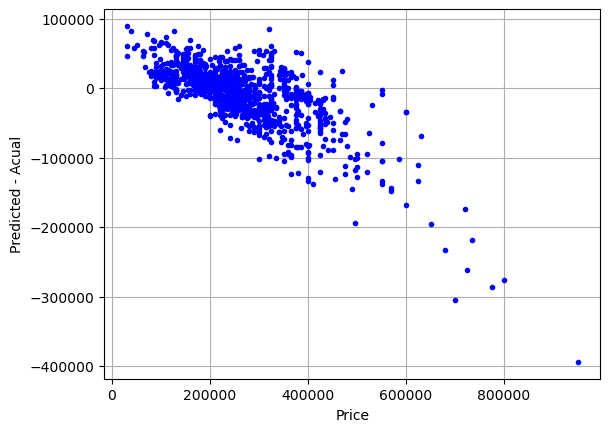

In [33]:
# evaluate
predict_evaluate(random_search_forest_model_with_pca.best_estimator_, X_train, y_train, True)

### Evaluate best model on test data
The random forest (without PCA) proved to be the best estimator in training. Let's see how this fares on the test data

In [36]:
best_model = random_search_forest_model.best_estimator_

RSME = 57102.20887291764


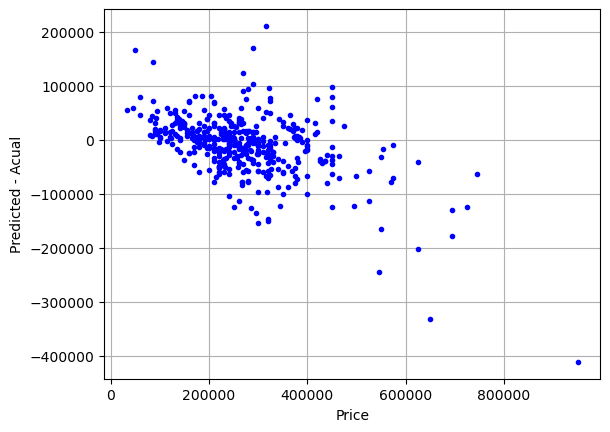

In [37]:
predict_evaluate(best_model, X_test, y_test, True)

### Final words

The overall test result is a bit worse than for the training data, which is expected. With an RMSE of ~£60,000, the model could be use to get a baseline estimate for the house asking price, but not an accurate score. Improvements could be made by adding in more features (through knowing the exact address of the house), adding more data points, or trying more models.